In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
import torchvision
from torchvision import datasets, models, transforms

In [4]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [5]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageClassifierData as ImageClassifierData
from Transforms.ImageTransforms import *

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 770', True)

In [8]:
DATA_PATH = Path('F:/fastai/courses/dl2/data/road_damage_dataset')

In [9]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [10]:
im_size = 224

In [11]:
train_tfms = TransformList([
        RandomScale(im_size, 1.2),
        RandomCrop(im_size),
        RandomLighting(0.05, 0.05),
        RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = TransformList([
        Scale(im_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [12]:
#test_tfms = TransformList([
#        RandomScale(im_size, 1.2),
#        RandomCrop(im_size),
#        RandomLighting(0.05, 0.05),
#        RandomHorizontalFlip()
#])
#
#for i in range(10, 20):
#    f, ax = plt.subplots(1,2, figsize=(10, 10))
#    print_example(images[i], ax[0])
#    im = open_image(DATA_PATH/images[i].filename) 
#    ax[1].imshow(test_tfms(im, 0)[0])
#    ax[0].get_xaxis().set_visible(False)
#    ax[0].get_yaxis().set_visible(False)
#    ax[1].get_xaxis().set_visible(False)
#    ax[1].get_yaxis().set_visible(False)   

In [13]:
batch_size = 8
data = ImageClassifierData.from_csv(DATA_PATH, MULTICLASS_CSV_PATH, batch_size, train_tfms, val_tfms)
num_classes = 8

In [47]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
model_ft.fc = nn.Sequential(
    nn.BatchNorm1d(num_features=num_ftrs),
    nn.Dropout(p=.5),
    nn.Linear(num_ftrs, num_classes),
    nn.Sigmoid()
)

In [ ]:
criterion = nn.BCELoss()
optim_fn = optim.Adam

In [53]:
[*[1e-3] * 9, 1e-2]

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.01]

In [54]:
sess = Session(model_ft, criterion, optim_fn, [*[1e-3] * 9, 1e-2])

In [55]:
sess.freeze() 

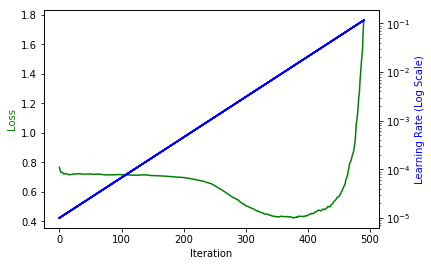

In [56]:
lr_find(sess, data['train'], start_lr=1e-5)

In [57]:
sess.set_lr(5e-3)

In [58]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 3)

Training Loss: 0.402018  Validaton Loss: 0.376544 Validation Accuracy: 0.831259


Training Loss: 0.382599  Validaton Loss: 0.377005 Validation Accuracy: 0.829530


Training Loss: 0.369997  Validaton Loss: 0.367224 Validation Accuracy: 0.835667


In [59]:
for detail in accuracy.details:
    print(detail)

{'correct_pos': 31, 'correct_neg': 1034, 'false_pos': 30, 'false_neg': 351}
{'correct_pos': 237, 'correct_neg': 784, 'false_pos': 127, 'false_neg': 298}
{'correct_pos': 0, 'correct_neg': 1350, 'false_pos': 0, 'false_neg': 96}
{'correct_pos': 0, 'correct_neg': 1354, 'false_pos': 0, 'false_neg': 92}
{'correct_pos': 130, 'correct_neg': 998, 'false_pos': 81, 'false_neg': 237}
{'correct_pos': 0, 'correct_neg': 1380, 'false_pos': 0, 'false_neg': 66}
{'correct_pos': 56, 'correct_neg': 1293, 'false_pos': 11, 'false_neg': 86}
{'correct_pos': 208, 'correct_neg': 812, 'false_pos': 112, 'false_neg': 314}


In [60]:
sess.save('TrainLayer1')

In [61]:
sess.load('TrainLayer1')

In [62]:
sess.unfreeze()

In [ ]:
lr_find(sess, data['train'], start_lr=[*[1e-6] * 9, 1e-5])

In [ ]:
sess.set_lr(1e-3)

In [ ]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 7)

In [ ]:
for detail in accuracy.details:
    print(detail)

In [ ]:
lr_scheduler.plot()

In [ ]:
sess.save('FullTrain')

In [ ]:
sess.load('FullTrain')

In [ ]:
sess.train(schedule, 8)

In [ ]:
sess.save('FullTrain2')

In [ ]:
sess.load('FullTrain2')